# Quantify the model behavior under a random climate
@TODO:

In [1]:
# import section
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Load data from files.

In [146]:
# specify path and read datasets
path = '/Users/oberrauch/work/master/data/cluster_output/showcase_glaciers_random_climate/eq_runs.nc'
ds = xr.open_dataset(path)
# sort by temperature bias
ds = ds.sortby('temp_bias')
ds['normalized'] = [bool(norm) for norm in ds.normalized]

# remove spinup period
ds = ds.isel(time=slice(1000,None))

# mass balance data set
path = '/Users/oberrauch/work/master/data/cluster_output/showcase_glaciers_random_climate/mb_output.nc'
ds_mb = xr.open_dataset(path)
# sort by temperature bias
ds_mb = ds_mb.sortby('temp_bias')

# read showcase glaciers
showcase_glaciers = pd.read_csv('/Users/oberrauch/work/master/data/showcase_glaciers.csv', index_col=0)
showcase_glaciers = showcase_glaciers.loc[[f'RGI60-11.{i:05d}' for i in [897, 106, 3643, 3638, 1450, 1238]]]

I wrote my own "statistics" snippet, but it turns out that you can just apply `.std()` or `.mean()` to a Dataset along any dimension.

In [39]:
norm = False
mb_model = 'random'

# create empty container
stats = list()
    
# iterate over both evolution models and all glaciers and tempertaure biases
for model in ds.model:
    for rgi_id in ds.rgi_id:
        for temp_bias in ds.temp_bias:
            length = ds.sel(model=model, rgi_id=rgi_id, temp_bias=temp_bias,
                            normalized=norm, mb_model=mb_model).length
            stats_ = length.to_dataframe()['length'].describe()
            # store simple stats in container
            stats.append(stats_.to_dict())
            

In [69]:
# store information of interest in Dataset
stats_ds = xr.Dataset()
for idx in ['mean', 'std']:
    stat = [stat[idx] for stat in stats]
    # reshape to allow for model, rgi id and temperature bias as coordinates
    stat = np.reshape(stat, (ds.model.size, ds.rgi_id.size, ds.temp_bias.size))
    stats_ds[idx] = (('model', 'rgi_id', 'temp_bias'), stat)

# add actual coordinate values
stats_ds.coords['model'] = ('model', ds.model)
stats_ds.coords['rgi_id'] = ('rgi_id', ds.rgi_id)
stats_ds.coords['temp_bias'] = ('temp_bias', ds.temp_bias)

In [157]:
std_ds = ds.std(dim='time').sel(normalized=False, rgi_id=showcase_glaciers.index,).squeeze().length

<AxesSubplot:xlabel='model,temp_bias'>

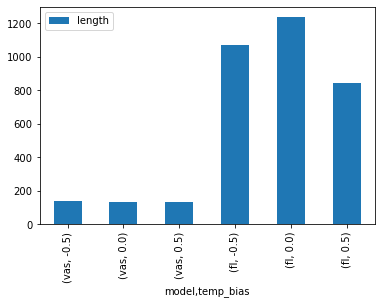

In [168]:
std_ds.sel(rgi_id='RGI60-11.01450').to_dataframe().plot.bar()

In [154]:
colors = ['C0', 'C1']
for model, c in zip(ds.model, colors):
    s = ds.std(dim='time').sel(normalized=False,
                               rgi_id=showcase_glaciers.index,
                               model=model).squeeze().length
    text = [f"{s_.rgi_id.values}: {s_.values:.0f}\n" for s_ in s.std(dim='temp_bias')]
    print(''.join(text))

RGI60-11.00897: 1
RGI60-11.00106: 0
RGI60-11.03643: 0
RGI60-11.03638: 0
RGI60-11.01450: 1
RGI60-11.01238: 2

RGI60-11.00897: 6
RGI60-11.00106: 141
RGI60-11.03643: 133
RGI60-11.03638: 79
RGI60-11.01450: 162
RGI60-11.01238: 98



In [150]:
showcase_glaciers

,name
rgi_id,
RGI60-11.00897,Hintereisferner
RGI60-11.00106,Pasterze
RGI60-11.03643,Mer de Glace
RGI60-11.03638,Glacier d'Argentière
RGI60-11.01450,Großer Aletschgletscher
RGI60-11.01238,Rhonegletscher


Compute the power spectral density for all glaciers and all temperature biases. Thereby it is possible to cut a given number of years at the beginning, during which the model glacier adjusted to the new given climatic conditions.

In [3]:
# define number of year to cut at the beginning
spinup_time = int(1e3)

# create empty container
data = list()

# iterate over all above selected glaciers
for rgi_id, glacier in showcase_glaciers.iterrows():
    # select glacier
    rgi_id = rgi_id
    name = glacier['name']
    # select from complete dataset
    ds_sel = ds.sel(normalized=False,
                    mb_model='random',
                    rgi_id=rgi_id)
    # truncate spinup if necessary
    ds_sel = ds_sel.isel(time=slice(spinup_time, None))

    # create empty container
    data_glacier = list()

    # iterate over both evolution models
    models = ['fl', 'vas']
    for model in models:

        # create empty container
        data_model = list()

        # iterate over all temperature biases
        for i, b in enumerate(np.sort(ds.temp_bias)):

            # select values by temperature bias
            ds_tmp = ds_sel.sel(temp_bias=b).length
            # compute the power of the signel per frequency band
            sig = ds_tmp.sel(model=model).values.flatten()
            freqs, psd = signal.welch(sig)
            # create Dataset
            tmp = pd.DataFrame({'psd':psd}, index=pd.Index(freqs, name='freq'))
            tmp = tmp.to_xarray()
            # add periods as coordinates
            periods = 1 / freqs
            # add temperature bias as dimension
            tmp.coords['temp_bias'] = b
            # add to container
            data_model.append(tmp)

        # concate along temperature bias dimension
        data_model = xr.concat(data_model, 'temp_bias')
        # add model as coordinate
        data_model.coords['model'] = model

        # add to container
        data_glacier.append(data_model)

    # combine datasets along model dimension
    data_glacier = xr.concat(data_glacier, 'model')
    data_glacier.coords['rgi_id'] = rgi_id
    # add to container
    data.append(data_glacier)

# combine along rgi id dimension
data = xr.concat(data, 'rgi_id')
# add glacier name as coordinate of dimesnion rgi_id
data.coords['name'] = ('rgi_id', showcase_glaciers['name'].values)

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


1800.2

In [71]:
# define number of year to cut at the beginning
spinup_time = int(1e3)

# create empty container
data = list()

# iterate over all above selected glaciers
for rgi_id, glacier in showcase_glaciers.iterrows():
    # select glacier
    rgi_id = rgi_id
    name = glacier['name']
    # select from complete dataset
    ds_sel = ds.sel(normalized=False,
                    mb_model='random',
                    rgi_id=rgi_id)
    # truncate spinup if necessary
    ds_sel = ds_sel.isel(time=slice(spinup_time, None))

    # create empty container
    data_glacier = list()

    # iterate over both evolution models
    models = ['fl', 'vas']
    for model in models:

        # create empty container
        data_model = list()

        # iterate over all temperature biases
        for i, b in enumerate(np.sort(ds.temp_bias)):

            # select values by temperature bias
            ds_tmp = ds_sel.sel(temp_bias=b).length
            # compute the power of the signel per frequency band
            sig = ds_tmp.sel(model=model).values.flatten()
            freqs, psd = signal.welch(sig, nperseg=int(len(sig)/5))
            # create Dataset
            tmp = pd.DataFrame({'psd':psd}, index=pd.Index(freqs, name='freq'))
            tmp = tmp.to_xarray()
            # add periods as coordinates
            periods = 1 / freqs
            # add temperature bias as dimension
            tmp.coords['temp_bias'] = b
            # add to container
            data_model.append(tmp)

        # concate along temperature bias dimension
        data_model = xr.concat(data_model, 'temp_bias')
        # add model as coordinate
        data_model.coords['model'] = model

        # add to container
        data_glacier.append(data_model)

    # combine datasets along model dimension
    data_glacier = xr.concat(data_glacier, 'model')
    data_glacier.coords['rgi_id'] = rgi_id
    # add to container
    data.append(data_glacier)

# combine along rgi id dimension
data = xr.concat(data, 'rgi_id')
# add glacier name as coordinate of dimesnion rgi_id
data.coords['name'] = ('rgi_id', showcase_glaciers['name'].values)

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


Take a quick look at the data, to get a feel for the dataset.

In [9]:
data

<xarray.Dataset>
Dimensions:    (freq: 129, model: 2, rgi_id: 6, temp_bias: 3)
Coordinates:
  * temp_bias  (temp_bias) float64 -0.5 0.0 0.5
  * freq       (freq) float64 0.0 0.003906 0.007812 ... 0.4922 0.4961 0.5
  * model      (model) object 'fl' 'vas'
  * rgi_id     (rgi_id) object 'RGI60-11.00897' ... 'RGI60-11.01238'
    name       (rgi_id) object 'Hintereisferner' 'Pasterze' ... 'Rhonegletscher'
Data variables:
    psd        (rgi_id, model, temp_bias, freq) float64 7.606e+05 ... 0.01333

In [63]:
data['rgi_id'].to_index()

Index(['RGI60-11.00897', 'RGI60-11.00106', 'RGI60-11.03643', 'RGI60-11.03638',
       'RGI60-11.01450', 'RGI60-11.01238'],
      dtype='object', name='rgi_id')

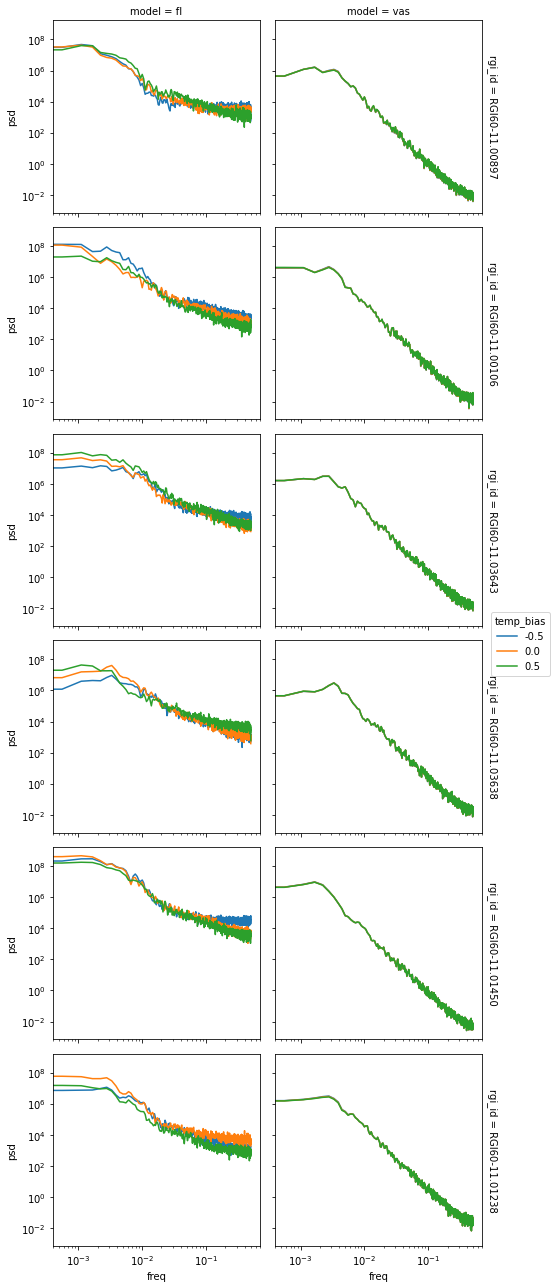

In [72]:
data.psd.plot.line(x='freq', xscale='log', yscale='log', col='model', row='rgi_id');

The plots show that the flowline model allows for different behavior under different climatic conditions, or rather differnt sizes of the same glacier. The VAS model does not, since there are no discernable differences between the runs with different temperature biases.

Hereafter I try/tried to quantify this phenomena... but I'dont really know how.

## Quantify spread in PSD for flowline model vs. no spread for VAS model
First let's look at all runs in one single plot.

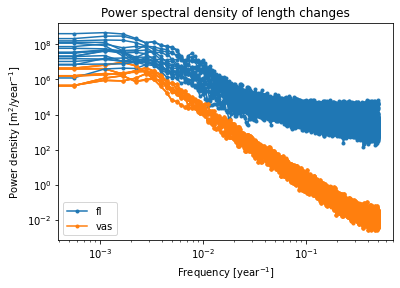

In [73]:
# iterate over all glaciers
for rgi_id in data.rgi_id:
    # iterate over all evolution models
    colors = ['C0', 'C1']
    for model, c in zip(data.model, colors):
        data.sel(rgi_id=rgi_id, model=model).psd.plot.line(x='freq', color=c, label=model.values, marker='.',
                                                           xscale='log', yscale='log', add_legend=False)
        
# legend
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[:4:3], l[:4:3], loc=3)
# title, labels
plt.xlabel('Frequency [year$^{-1}$]')
plt.ylabel('Power density [m$^{2}/$year$^{-1}$]')
plt.title('Power spectral density of length changes');

Now I establish some basic measures like the mean, the minimum and maximum.

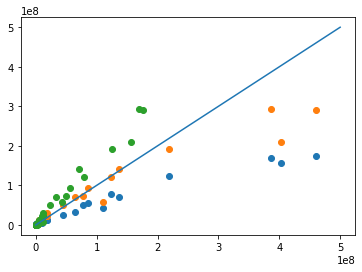

In [133]:
rgi_id = 'RGI60-11.01450'
model='fl'
plt.scatter(data.sel(model=model, rgi_id=rgi_id, temp_bias=0).psd,
            data.sel(model=model, rgi_id=rgi_id, temp_bias=0.5).psd)
plt.scatter(data.sel(model=model, rgi_id=rgi_id, temp_bias=0).psd,
            data.sel(model=model, rgi_id=rgi_id, temp_bias=-0.5).psd)
plt.scatter(data.sel(model=model, rgi_id=rgi_id, temp_bias=0.5).psd,
            data.sel(model=model, rgi_id=rgi_id, temp_bias=-0.5).psd)
plt.plot([0,5e8], [0,5e8])

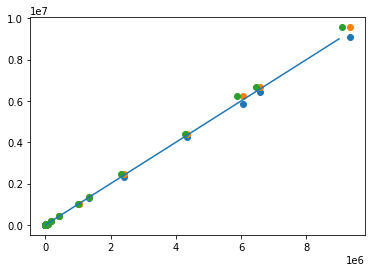

In [137]:
rgi_id = 'RGI60-11.01450'
model='vas'
plt.scatter(data.sel(model=model, rgi_id=rgi_id, temp_bias=0).psd,
            data.sel(model=model, rgi_id=rgi_id, temp_bias=0.5).psd)
plt.scatter(data.sel(model=model, rgi_id=rgi_id, temp_bias=0).psd,
            data.sel(model=model, rgi_id=rgi_id, temp_bias=-0.5).psd)
plt.scatter(data.sel(model=model, rgi_id=rgi_id, temp_bias=0.5).psd,
            data.sel(model=model, rgi_id=rgi_id, temp_bias=-0.5).psd)
plt.plot([0,9e6], [0,9e6])

In [78]:
# compute mean over all glaciers and temperature biases
mean = data.mean(dim=['temp_bias', 'rgi_id']).psd
# find lowest and highest values
max_psd = data.psd.max(dim=['temp_bias', 'rgi_id'])
min_psd = data.psd.min(dim=['temp_bias', 'rgi_id'])

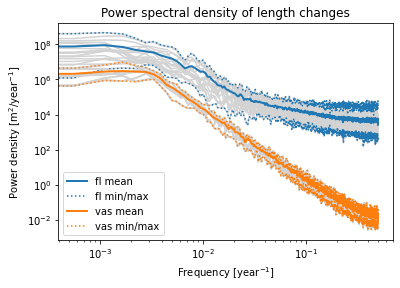

In [79]:
# iterate over all evolution models
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    # iterate over all glaciers
    for rgi_id in data.rgi_id:
        data.sel(rgi_id=rgi_id, model=model).psd.plot.line(x='freq', color='lightgrey',
                                                           xscale='log', yscale='log',
                                                           add_legend=False)
        
    mean.sel(model=model).plot.line(c=c, lw=2, label=f'{model.values} mean')
    max_psd.sel(model=model).plot.line(c=c, ls=':', label=f'{model.values} min/max')
    min_psd.sel(model=model).plot.line(c=c, ls=':')

# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Frequency [year$^{-1}$]')
plt.ylabel('Power density [m$^{2}/$year$^{-1}$]')
plt.title('Power spectral density of length changes');

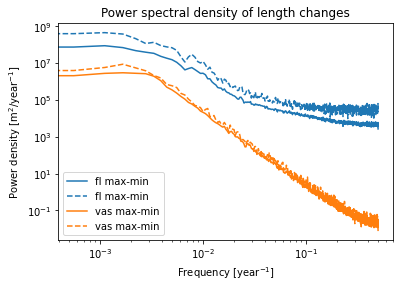

In [80]:
# compute spread
spread = max_psd - min_psd
# plot mean and spread
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    mean.sel(model=model).plot.line(xscale='log', yscale='log', ls='-', c=c,
                                    label=f'{model.values} max-min')
    spread.sel(model=model).plot.line(xscale='log', yscale='log', c=c,
                                      ls='--', label=f'{model.values} max-min')
    
# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Frequency [year$^{-1}$]')
plt.ylabel('Power density [m$^{2}/$year$^{-1}$]')
plt.title('Power spectral density of length changes');

**Min/max spread in relation to the average**

In [81]:
# compute relation between spread and mean
rel_spread = spread/mean

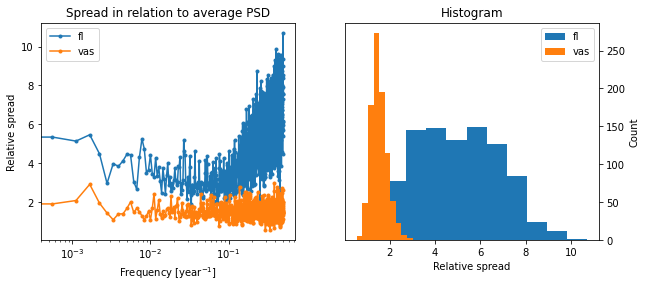

In [82]:
# visualize relative spread
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10,4])

# per frequency
rel_spread.plot.line(x='freq', xscale='log', marker='.',
                     add_legend=False, label='dummy_label',
                     ax=ax0)

# legend, title, labels
ax0.legend(ax0.get_legend_handles_labels()[0], ['fl', 'vas'])
ax0.set_xlabel('Frequency [year$^{-1}$]')
ax0.set_ylabel('Relative spread')
ax0.set_title('Spread in relation to average PSD');

# histogram
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    rel_spread.sel(model=model).plot.hist(label=f'{model.values}', ax=ax1, color=c)
# legend, title, labels
ax1.legend()
ax1.set_xlabel('Relative spread')
ax1.set_ylabel('Count')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

Does the followin steatment make any sense, whatsoever?

The PSD of the VAS model for different glaciers and under different climatic conditions spreads approximately 1.5 times of the average over all runs. The PSD of the flowline model for different runs spreads approximately 4 times of the average of all runs, whereby the spread increases to 8 time the average for small frequencies?!

As another measure I'll look at the relative difference between the minimum and maximum PSD value for each model. By relative difference I mean the following
$$\Delta_\text{rel.}(a,b) = \frac{|a-b|}{\frac{a+b}{2}}$$

**Relative difference**

In [83]:
def relative_difference(a,b):
    """Compute the relative difference between a and b as |a-b|/(1/2*(a+b))"""
    return abs(a-b)/np.mean([a,b])

In [84]:
# compute realtive difference
rd = relative_difference(max_psd, min_psd)

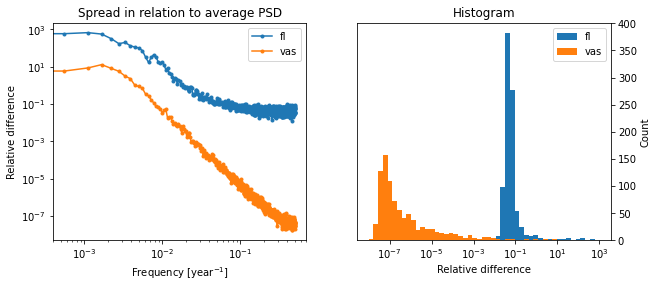

In [85]:
# visualize relative spread
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10,4])

# per frequency
rd.plot.line(x='freq', xscale='log', yscale='log', marker='.',
                     add_legend=False, label='dummy_label',
                     ax=ax0)

# legend, title, labels
ax0.legend(ax0.get_legend_handles_labels()[0], ['fl', 'vas'])
ax0.set_xlabel('Frequency [year$^{-1}$]')
ax0.set_ylabel('Relative difference')
ax0.set_title('Spread in relation to average PSD');

# histogram
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    rd.sel(model=model).plot.hist(bins=np.logspace(np.log10(1e-8),np.log10(1e3), 50),
                                  label=f'{model.values}', ax=ax1, color=c)
ax1.set_xscale('log')
# legend, title, labels
ax1.legend()
ax1.set_xlabel('Relative difference')
ax1.set_ylabel('Count')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

And again my question: Does the followin steatment make any sense, whatsoever?
    
For the VAS model, the relative difference between maximum and minimum values of the PSD is in the order of 100% for low frequencies and drops to a negligible 10$^{-8}$ for higher frequencies. For the flowline model, the relative differences get as high as 2500% for low frequencies and drop to around 10% for high frequencies.

## Slope of the energy cascade

The PSD of the flowline model has characteristics of a low pass fiter, while the PSD of the VAS model reminds of the energy cascade (see https://en.wikipedia.org/wiki/Energy_cascade). The energy cascade is characterized by a specific slope/gradient (-5/3) in the inertial subrange (transfer range), which represents the exponent of the relation between energy and wave number $E(k) \propto k^{-5/3}$.

In the following, I'm computing the slope for the VAS PSD... even if I don't know how to interpret it yet.

**Compute slope for mean PSD**

In [90]:
# select middle frequencies, in analogy to the transfer range
psd_sel = mean.sel(freq=slice(0.005,0.3), model='vas')

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


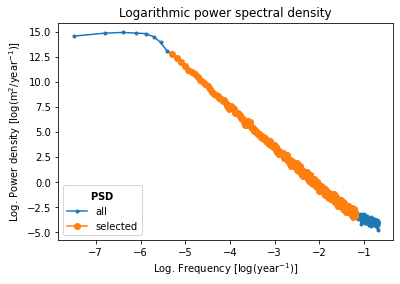

In [91]:
# plot mean
plt.plot(np.log(mean.freq).values, np.log(mean.sel(model='vas')).values, c='C0', marker='.', label='all')

# plot selected values
x = np.log(psd_sel.freq.values).reshape((-1, 1))
y = np.log(psd_sel.values.flatten())
plt.plot(x,y, marker='o', ls=None, c='C1', label='selected')

# legend, title, labels
plt.legend(loc=3, title='$\\bf{PSD}$',)
plt.xlabel('Log. Frequency [log(year$^{-1}$)]')
plt.ylabel('Log. Power density [log(m$^{2}/$year$^{-1}$)]')
plt.title('Logarithmic power spectral density');

In [92]:
# compute linear regression
reg = LinearRegression().fit(x, y)
# display results
print('Linear regression:\n------------------')
print(f'slope: {reg.coef_[0]:.2f}')
print(f'r^2: {reg.score(x, y):.3f}')

Linear regression:
------------------
slope: -3.85
r^2: 0.996


/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


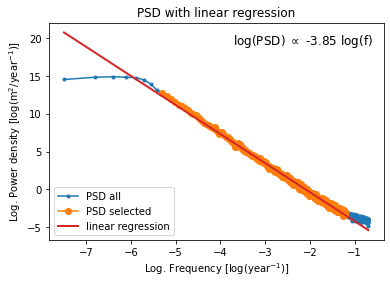

In [93]:
# visualize linear regression
# plot mean
mean_x = np.log(mean.freq).values
plt.plot(mean_x, np.log(mean.sel(model='vas')).values, c='C0', marker='.', label='PSD all')

# plot selected values
x = np.log(psd_sel.freq.values).reshape((-1, 1))
y = np.log(psd_sel.values.flatten())
plt.plot(x, y, marker='o', ls=None, c='C1', label='PSD selected')

# plot linear regression
lr_x = np.array([min(mean_x[mean_x != -np.inf]), max(mean_x[mean_x != -np.inf])])
plt.plot(lr_x, lr_x*reg.coef_+reg.intercept_, lw=2, c='C3', label='linear regression')

# add 
plt.text(0.55, 0.9, f'log(PSD) $\\propto$ {reg.coef_[0]:.2f} log(f)',
         fontsize='large', transform=plt.gca().transAxes)

# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Log. Frequency [log(year$^{-1}$)]')
plt.ylabel('Log. Power density [log(m$^{2}/$year$^{-1}$)]')
plt.title('PSD with linear regression');

Ok, this test was successful. Let's see what happens for all data points...

**Compute slope for all points of PSD:**

Repeat the computation of the linear regression from above, for both evolution models.

In [116]:
psd_sel = data.sel(freq=slice(0.005,0.1), model='vas').psd
# get data points
x = np.log(np.tile(psd_sel.freq.values, 18).flatten()).reshape((-1,1))
y = np.log(psd_sel.values.flatten())
# compute linear regression
reg = LinearRegression().fit(x, y)
# display results
print('Linear regression:\n------------------')
print(f'slope: {reg.coef_[0]:.2f}')
print(f'r^2: {reg.score(x, y):.3f}')

Linear regression:
------------------
slope: -4.03
r^2: 0.954


/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


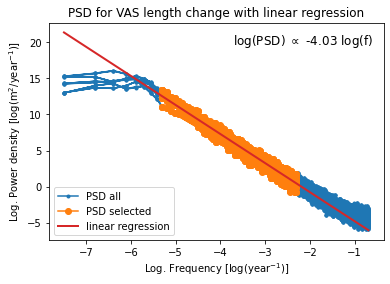

In [117]:
# visualize linear regression
# plot mean
psd_vas = data.sel(model='vas').psd
data_x = np.tile(np.log(psd_vas.freq).values, 18)
plt.plot(data_x, np.log(psd_vas).values.flatten(), c='C0', marker='.', label='PSD all')

# plot selected values
plt.plot(x, y, marker='o', ls=None, c='C1', label='PSD selected')

# plot linear regression
lr_x = np.array([min(mean_x[mean_x != -np.inf]), max(mean_x[mean_x != -np.inf])])
plt.plot(lr_x, lr_x*reg.coef_+reg.intercept_, lw=2, c='C3', label='linear regression')

# add 
plt.text(0.55, 0.9, f'log(PSD) $\\propto$ {reg.coef_[0]:.2f} log(f)',
         fontsize='large', transform=plt.gca().transAxes)

# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Log. Frequency [log(year$^{-1}$)]')
plt.ylabel('Log. Power density [log(m$^{2}/$year$^{-1}$)]')
plt.title('PSD for VAS length change with linear regression');

The slope did not change (at least up to the second decimal point), only the coefficient of determination got slightly worse. Since it still ~95% it is fine. No I have a slope of -3.85 (units???) and don't know what to do with it...

In [114]:
psd_sel = data.sel(freq=slice(0.005,0.1), model='fl').psd
# get data points
x = np.log(np.tile(psd_sel.freq.values, 18).flatten()).reshape((-1,1))
y = np.log(psd_sel.values.flatten())
# compute linear regression
reg = LinearRegression().fit(x, y)
# display results
print('Linear regression:\n------------------')
print(f'slope: {reg.coef_[0]:.2f}')
print(f'r^2: {reg.score(x, y):.3f}')

Linear regression:
------------------
slope: -1.95
r^2: 0.679


/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


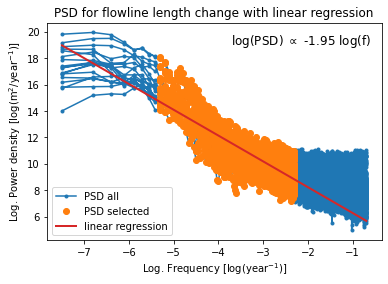

In [115]:
# visualize linear regression
# plot mean
psd_vas = data.sel(model='fl').psd
data_x = np.tile(np.log(psd_vas.freq).values, 18)
plt.plot(data_x, np.log(psd_vas).values.flatten(), c='C0', marker='.', label='PSD all')

# plot selected values
plt.plot(x, y, marker='o', ls='None', c='C1', label='PSD selected')

# plot linear regression
lr_x = np.array([min(mean_x[mean_x != -np.inf]), max(mean_x[mean_x != -np.inf])])
plt.plot(lr_x, lr_x*reg.coef_+reg.intercept_, lw=2, c='C3', label='linear regression')

# add 
plt.text(0.55, 0.9, f'log(PSD) $\\propto$ {reg.coef_[0]:.2f} log(f)',
         fontsize='large', transform=plt.gca().transAxes)

# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Log. Frequency [log(year$^{-1}$)]')
plt.ylabel('Log. Power density [log(m$^{2}/$year$^{-1}$)]')
plt.title('PSD for flowline length change with linear regression');